# Task 4 Explainability

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from my_model_selection import evaluate_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from interpret import show
from interpret.blackbox import LimeTabular


In [4]:
df_incidents_prepared = pd.read_csv('../dataset_preparation/incidents_prepared.csv', index_col=0)
df_orig = pd.read_csv('../dataset_preparation/original_features.csv', index_col=0)

We join the original dataset and the one obtained in the Data Preparation phase in order to have all the features in the same dataset

In [5]:
df_incidents_prepared=df_incidents_prepared.join(df_orig)
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 16

In [6]:
# We add the feature to predict (as in the Classification task): isKilled
df_incidents_prepared['isKilled'] = df_incidents_prepared['n_killed'] > 0

In [7]:
cols2drop=[
            #categorical features difficult to encode
           'address', 'city_or_county','congressional_district','date','state', 'year_month',
           'avg_age_participants', # we already have age_group
           'n_killed',  #gives directly the label isKilled
           'incident_characteristics1', # too similar to the label isKilled
           'severity', 'severity_cat', # created from n_killed

           # we decided to use original features n_females, n_injured etc. all those features are highly correlated. We decided to keep the original features because they are more interpretable
           'killed_by_district','injured_by_district', 'dfm_district_killed','dfm_district_injured', 'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen', 'dfm_district_females', 'arrested_ratio', 'unharmed_ratio', 'severity_minor',

           # correlated with n_participants
            'n_participants_adult'
            ]
df_incidents_prepared=df_incidents_prepared.drop(cols2drop, axis=1)

In [8]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   age_group               161550 non-null  object 
 4   povertyPercentage       161550 non-null  float64
 5   population              161550 non-null  int64  
 6   party                   161550 non-null  object 
 7   candidatevotes          161550 non-null  float64
 8   right_or_left           161550 non-null  float64
 9   voters_over_population  161550 non-null  float64
 10  n_arrested              161550 non-null  float64
 11  n_participants          161550 non-null  float64
 12  n_participants_teen     161550 non-null  float64
 13  n_participants_child    161550 non-null  float64
 14  n_females           

We proceed with eliminating from the train set the feature to predict: isKilled, moreover we follow the same approach as in the Classification task, so we drop the features `n_unharmed` and `n_arrested`. In fact, we saw that keeping both `n_injured` and these 2 features the task becomes too easy, but eliminating all these 3 features brought to bad performances. As a compromise, we decided to keep only `n_injured` and drop the other 2 features.

In [9]:
X = df_incidents_prepared.drop('isKilled', axis=1)
X.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)

y = df_incidents_prepared['isKilled']

X.head()

latitude  longitude    year age_group  povertyPercentage  population  \
0   39.8322   -86.2492  2015.0   [18-24]               12.3     6608422   
1   39.7745   -86.1166  2015.0   [25-34]               12.3     6608422   
2   39.7759   -86.2940  2015.0   [35-44]               12.3     6608422   
3   39.8040   -86.0095  2015.0   [18-24]               12.3     6608422   
4   39.7882   -86.2091  2015.0   [45-54]               12.3     6608422   

      party  candidatevotes  right_or_left  voters_over_population  \
0  DEMOCRAT         61443.0       0.452677                0.203046   
1  DEMOCRAT         61443.0       0.452677                0.203046   
2  DEMOCRAT         61443.0       0.452677                0.203046   
3  DEMOCRAT         61443.0       0.452677                0.203046   
4  DEMOCRAT         61443.0       0.452677                0.203046   

   n_participants  n_participants_teen  n_participants_child  n_females  \
0             1.0                  0.0                   0.0        0.0   
1             2.0                  0.0                   0.0        0.0   
2             2.0                  0.0                   0.0        0.0   
3             1.0                  0.0                   0.0        0.0   
4             1.0                  0.0                   0.0        0.0   

   n_males  n_injured  
0      1.0          1  
1      2.0          0  
2      2.0          0  
3      1.0          0  
4      1.0          1

In [10]:
# We encode the categorical features
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   povertyPercentage       161550 non-null  float64
 4   population              161550 non-null  int64  
 5   candidatevotes          161550 non-null  float64
 6   right_or_left           161550 non-null  float64
 7   voters_over_population  161550 non-null  float64
 8   n_participants          161550 non-null  float64
 9   n_participants_teen     161550 non-null  float64
 10  n_participants_child    161550 non-null  float64
 11  n_females               161550 non-null  float64
 12  n_males                 161550 non-null  float64
 13  n_injured               161550 non-null  int64  
 14  age_group_[0-11]    

In [11]:
X3_train, X3_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree
We choose to analyze the decision tree that gave the best results in the Classification task.

In [12]:
best_params_dt={
"criterion": 'gini',
"max_depth": 16,
"min_samples_split": 16
}
best_tree=DecisionTreeClassifier(**best_params_dt)
best_tree.fit(X3_train,y_train)

DecisionTreeClassifier(max_depth=16, min_samples_split=16)

In [13]:
y_pred = best_tree.predict(X3_test)

## Lime for DT
With LIME we can explain the prediction of a single instance. We can see the features that contributed the most to the prediction and how much they contributed. We show in particular the explanation for the first 3 instances of the test set.

In [14]:
import lime
import lime.lime_tabular

In [15]:
features = list(X.columns)
explainer = lime.lime_tabular.LimeTabularExplainer(X3_train.values, feature_names = features)

Let's see a correct False prediction. In this case `n_participants` is 9, but `n_injured` is 0.

In [16]:
exp = explainer.explain_instance(X3_test.values[85], best_tree.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Let's now see a correct True prediction

In [17]:
exp = explainer.explain_instance(X3_test.values[245], best_tree.predict_proba)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [18]:
# find a false negative and a false positive
y_pred = best_tree.predict(X3_test)
false_pos = np.where((y_pred == 1) & (y_test == 0))[0]
false_neg = np.where((y_pred == 0) & (y_test == 1))[0]
print(false_pos)
print(false_neg)

[    1     2     9 ... 32283 32285 32298]
[    8    12    13 ... 32293 32306 32307]


interpret library offers nice visualizations of the LIME values.
Below, we chose 4 instances, for each correct and incorrect prediction. In this case the orange bars are the features that push towards the _predicted_ class, while the blue ones are the features that push towards the _other_ class.
(in the previous plots the colors were always blue for False and orange for True)

In [19]:
from interpret.blackbox import LimeTabular

lime = LimeTabular(data=X3_test, random_state=1, model=best_tree)
expl = lime.explain_local(X3_test.iloc[[85, 245,1,8]], y_test.iloc[[85, 245,1, 8]])
show(expl, 0)

<!-- http://127.0.0.1:7001/2119920746352/ -->

## Shap for DT

In [20]:
import shap

In [21]:
expl_tree = shap.TreeExplainer(best_tree)
shap_values_tree = expl_tree.shap_values(X3_test)

### Global Explanation

We can see the summary plot of the SHAP values for the test set. This gives a global explanation of the model, i.e., the reasoning of the black-box model at a high level.
 
The plot shows the features ordered by importance. The importance is measured by the mean absolute value of the SHAP values over the test set. We can notice that `n_injured` is the most important feature, which explains why discarding it brought to bad performances in the Classification task. 

We can also notice that `n_participants` is the second most important feature, which is coherent with the fact that the more participants there are, the more likely it is that someone gets killed.

It is quite surprising instead that `latitude` is the third most important feature, which can perhaps be explained by the fact that there are areas with more accidents than others.

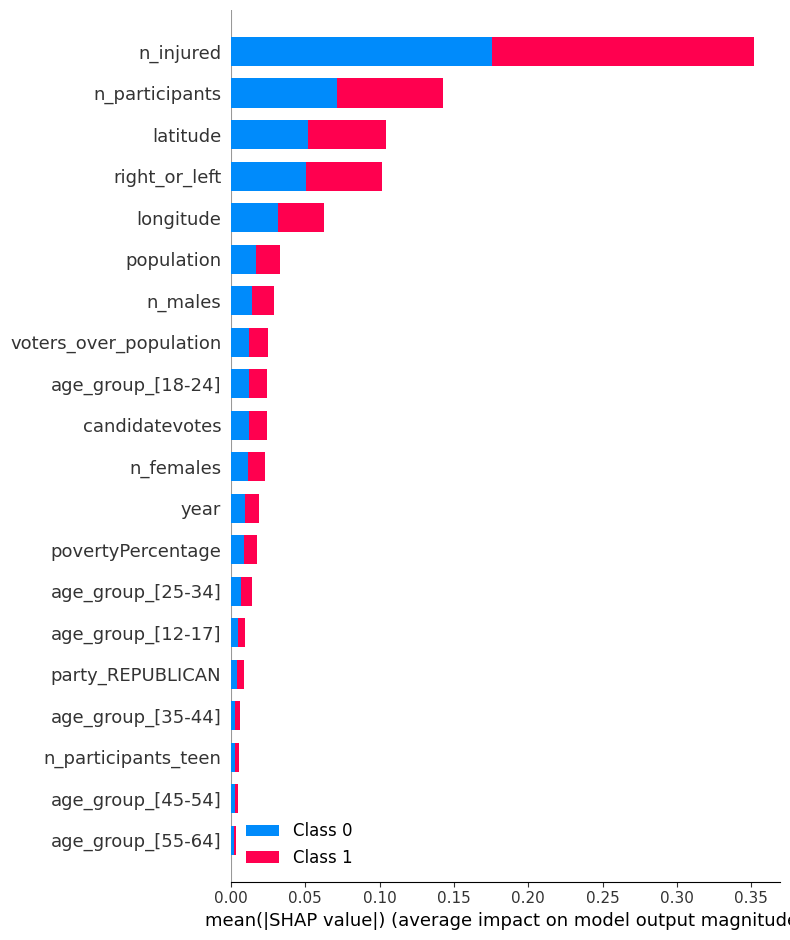

In [19]:
shap.summary_plot(shap_values_tree, X3_test)

Let's dive into the dependence plots. These plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. Moreover, specifying a feature to the parameter `interaction_index`, the scatter plot will be colored by that feature.

In [20]:
X3_test.shape

(32310, 25)

In [21]:
# This np.ndarray contains the SHAP values of the False label for each instance of the test set
shap_values_tree[0]

array([[ 3.57563061e-02,  1.26031881e-02, -9.27137363e-04, ...,
         4.22056429e-04, -5.06608882e-04,  3.62441435e-03],
       [ 4.61349942e-03, -2.43922520e-01, -4.72284890e-05, ...,
         7.16429720e-05, -1.15687051e-03, -6.64889768e-04],
       [-1.74104901e-01, -2.00967127e-01,  3.37930206e-03, ...,
         3.12101793e-04, -4.36689373e-04, -1.04594964e-03],
       ...,
       [ 5.97769490e-02,  7.72983274e-02,  9.57879353e-03, ...,
        -3.31930236e-04,  2.55623257e-04,  1.31191394e-03],
       [-4.23857028e-03,  4.66489416e-02, -1.64881170e-02, ...,
         4.99257634e-05, -9.39185752e-05, -7.27296747e-03],
       [ 3.98754211e-02, -1.59385045e-03,  8.76875723e-03, ...,
         3.10342006e-05,  4.19356753e-05,  3.83603738e-03]])

In [22]:
# This np.ndarray contains the SHAP values of the True label for each instance of the test set
shap_values_tree[1]

array([[-3.57563061e-02, -1.26031881e-02,  9.27137363e-04, ...,
        -4.22056429e-04,  5.06608882e-04, -3.62441435e-03],
       [-4.61349942e-03,  2.43922520e-01,  4.72284890e-05, ...,
        -7.16429720e-05,  1.15687051e-03,  6.64889768e-04],
       [ 1.74104901e-01,  2.00967127e-01, -3.37930206e-03, ...,
        -3.12101793e-04,  4.36689373e-04,  1.04594964e-03],
       ...,
       [-5.97769490e-02, -7.72983274e-02, -9.57879353e-03, ...,
         3.31930236e-04, -2.55623257e-04, -1.31191394e-03],
       [ 4.23857028e-03, -4.66489416e-02,  1.64881170e-02, ...,
        -4.99257634e-05,  9.39185752e-05,  7.27296747e-03],
       [-3.98754211e-02,  1.59385045e-03, -8.76875723e-03, ...,
        -3.10342006e-05, -4.19356753e-05, -3.83603738e-03]])

If we don't specify the `interaction_index` parameter, the scatter plot will be automatically colored by the feature which is considered the best, i.e., the one with the strongest interaction.

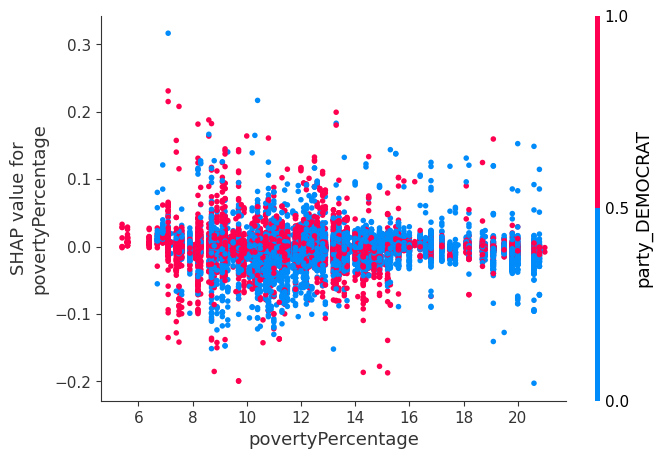

In [23]:
attr = "povertyPercentage"
shap.dependence_plot(ind=attr, shap_values=shap_values_tree[1], features=X3_test)

Let's see the dependence plot for the feature `n_injured`. We can see that the plot is automatically colored by the feature `n_participants`, which is the feature with the strongest interaction with `n_injured`.

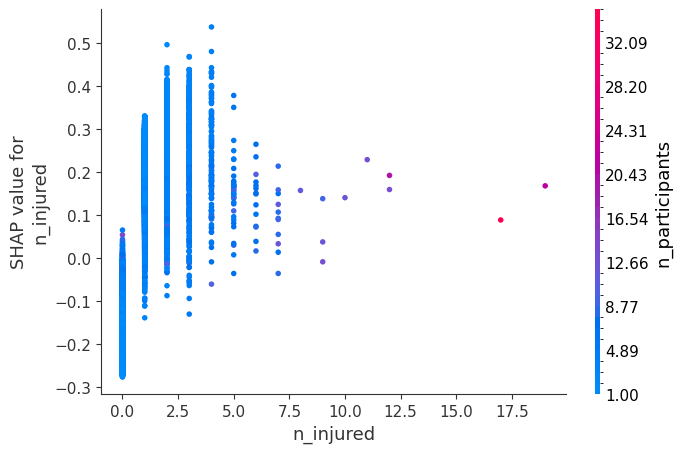

In [24]:
attr = "n_injured"
shap.dependence_plot(ind=attr, shap_values=shap_values_tree[0], features=X3_test)

If we want to see the dependence plot for the True label, we have to pass the second np.ndarray: shap_values_tree[1]. We can see that the plot is the same as the one above, but with specular SHAP values.


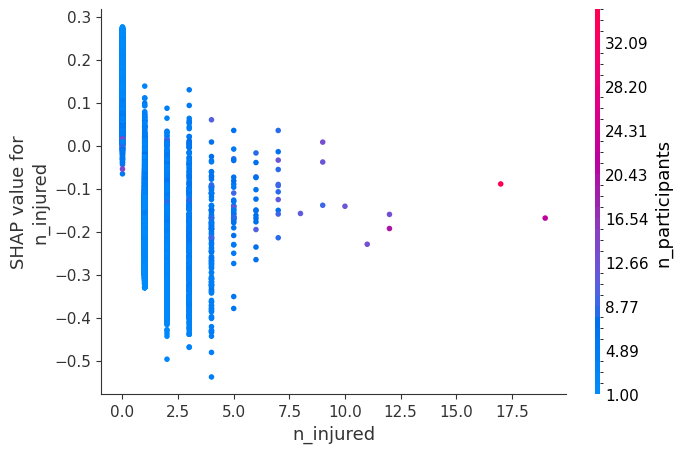

In [25]:
attr = "n_injured"
shap.dependence_plot(ind=attr, shap_values=shap_values_tree[1], features=X3_test, interaction_index="n_participants")

Finally, let's see the dependence plot for the feature `n_participants_teen`. We also colored the plot by the feature `age_group_[12-17]` which corresponds to the age of teens. 

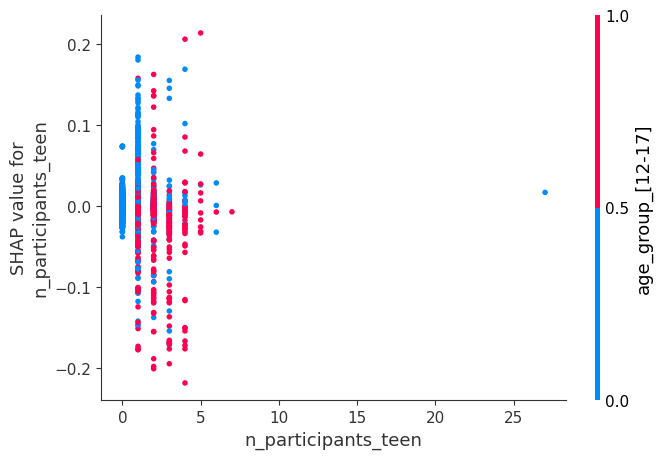

In [26]:
attr = "n_participants_teen"
shap.dependence_plot(ind=attr, shap_values=shap_values_tree[1], features=X3_test, interaction_index="age_group_[12-17]")

We decide to reapply expl_tree to the test set in order to have the SHAP values for the whole test set in the shap._explanation.Explanation object.

In [27]:
shap_values_t = expl_tree(X3_test)

In [28]:
type(shap_values_t)

shap._explanation.Explanation

In [29]:
shap_values_t[:,:,0].shape

(32310, 25)

Let's visualize in two other ways which were the most important features for the False and True labels.

We can show the standard plot of the SHAP values for the test set, which again shows that `n_injured` is the most important feature.

Another nice visualization is the beeswarm, which gives also some useful insights.

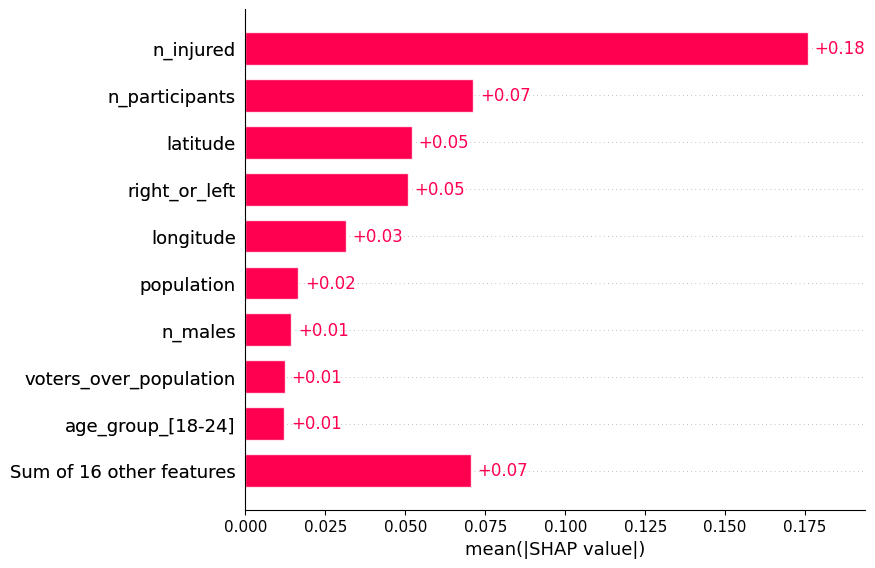

In [30]:
shap.plots.bar(shap_values_t[:,:,1])

# Notice that it is the same to pass shap_values_t[:,:,0] or shap_values_t[:,:,1] to the function since we show the mean of the absolute value of the SHAP values.

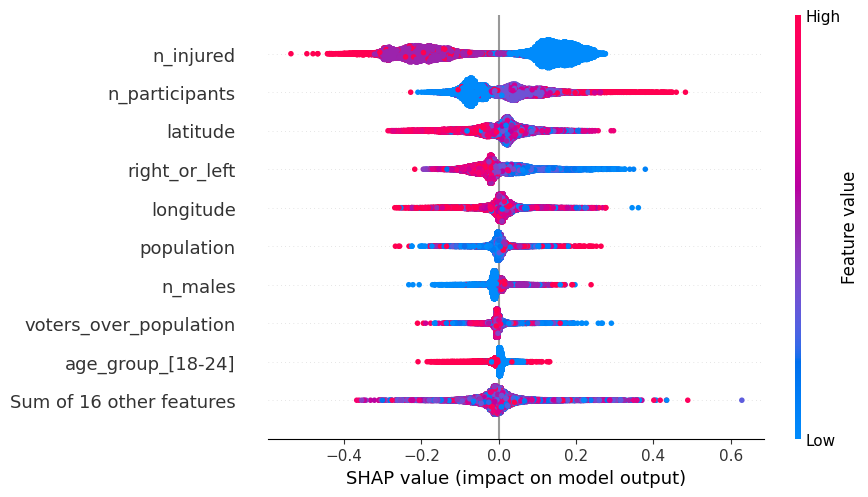

In [31]:
# summarize the effects of all the features with a beeswarm plot
shap.plots.beeswarm(shap_values_t[:,:,1])

On the above plot, positive SHAP values indicate an higher probability to be predicted as True, while negative to be predicted as False. 

The color approaches to fucsia as the feature value is higher, while it moves to cyan when it's lower.
 
Moreover, the agglomeration in correspondence of a certain SHAP value indicates that there are many instances with that SHAP value. For example, we can see that there are many instances with a SHAP value of 0 for the feature `age_group_[18-24]`.

Another interesting plot is the force plot, which shows the SHAP values for the single instances. We chose to show the force plot for the first 100 instances of the test set, and in the next section (Local Explanation) we will explain better how this force plot came out.

The first plot, which is ordered by similarity, gives us an idea of the class in which the instance has been classified, and how much the various features have contributed to this assignment. 

In the second plot we focused on `n_injured`: on the x-axis we have the number of injured people. We see that for 0 injured the probability that `isKilled` = 1 is higher, while for $\geq$ 1 injured people the probability that `isKilled` = 0 is higher. Notice that this observation is done looking only at the first 100 instances of the test set, so it is not a general rule.

In [32]:
shap.initjs()

In [33]:
shap.plots.force(shap_values_t[:100,:,0])
# giving shap_values_t[:100,:,0] the False cases are red, which correspond to `isKilled` = 0

In [34]:
shap.plots.force(shap_values_t[:100,:,0])

### Local Explanation
Let's understand how the force plot came out. We can select a single instance of the test set and see the contribution of each feature for that instance. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

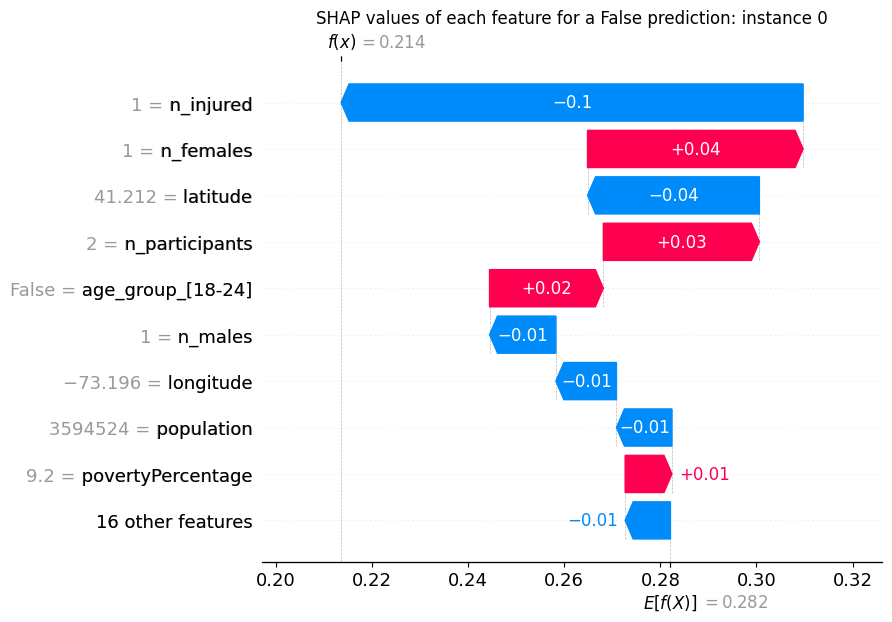

In [35]:
plt.title('SHAP values of each feature for a False prediction: instance 0')
shap.plots.waterfall(shap_values_t[0,:,1])

# As already said this instance was predicted as False, i.e., `isKilled` = 0 and the feature which contributed the most to this prediction is `n_injured`.

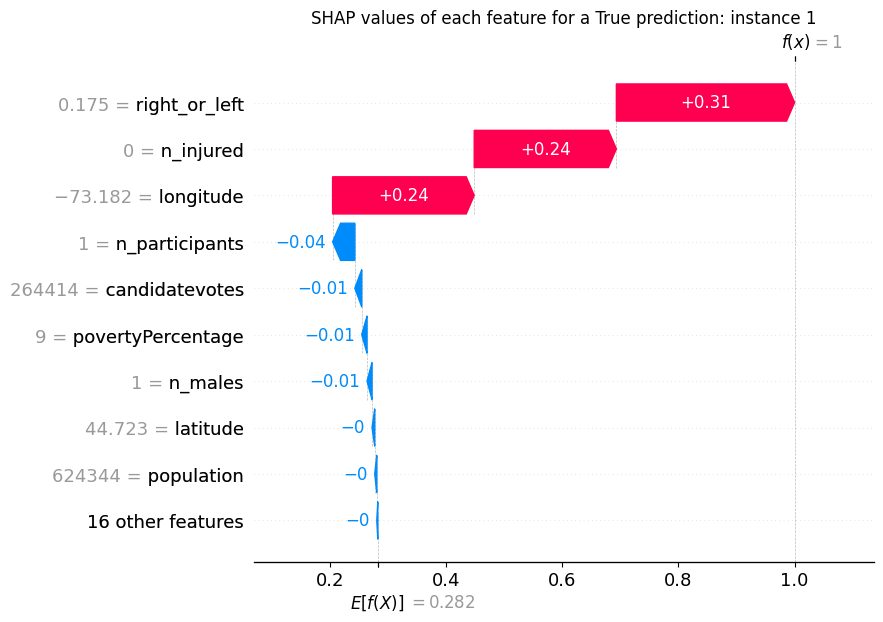

In [36]:
plt.title('SHAP values of each feature for a True prediction: instance 1')
shap.plots.waterfall(shap_values_t[1,:,1])

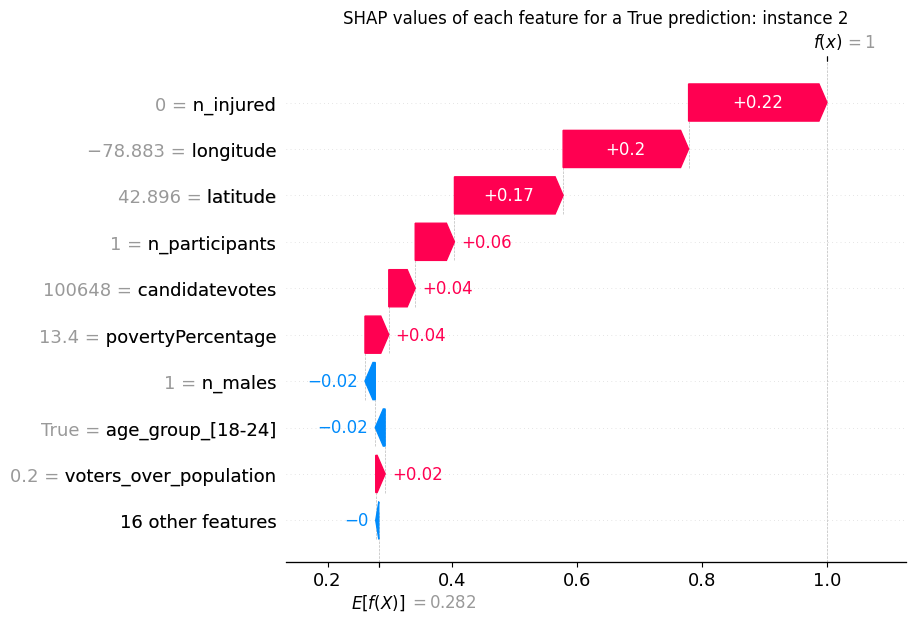

In [37]:
plt.title('SHAP values of each feature for a True prediction: instance 2')
shap.plots.waterfall(shap_values_t[2,:,1])

## Evaluation of faithfulness and monotonicity

Try on one instance

In [93]:
from aix360.metrics import faithfulness_metric, monotonicity_metric
import warnings
warnings.filterwarnings('ignore') # suppresses the warning about the model being fit with column names
predicted_class = best_tree.predict(X3_test.iloc[85:86])[0]
predicted_class = int(predicted_class)
x = X3_test.values[0]
# coefs the SHAP values for the predicted class
coefs = shap_values_tree[predicted_class][0]

base = np.zeros(x.shape[0])

faithfulness_shap_dt = faithfulness_metric(x=x, model=best_tree, coefs=coefs, base=base)
print("Faithfulness of LIME on decision trees: ", faithfulness_shap_dt)
monotonicity_shap_dt = monotonicity_metric(x=x, model=best_tree, coefs=coefs, base=base)
print('')
print("Monotonicity of Shap on decision trees: ", monotonicity_shap_dt)

Faithfulness of LIME on decision trees:  0.21144630339102477

Monotonicity of Shap on decision trees:  False


In [94]:
le = exp.local_exp[1]
coefs = np.zeros(x.shape[0])
for i in range(len(le)):
    coefs[le[i][0]] = le[i][1] # non zero coefficients are the ones that are in the local explanation

faithfulness_lime_dt = faithfulness_metric(x=x, model=best_tree, coefs=coefs, base=base)
print("Faithfulness of LIME on decision trees: ", faithfulness_lime_dt)
monotonicity_lime_dt = monotonicity_metric(x=x, model=best_tree, coefs=coefs, base=base)
print("Monotonicity of LIME on decision trees: ", monotonicity_lime_dt)

Faithfulness of LIME on decision trees:  -0.05646898956516357
Monotonicity of LIME on decision trees:  False


# Random Forest
We choose again to analyze the random forest that gave the best results in the Classification task.

In [200]:
from sklearn.ensemble import RandomForestClassifier

In [201]:
rf = RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_split=2, n_estimators=50)
rf.fit(X3_train, y_train)
y_pred = rf.predict(X3_test)

## Lime for Random Forests

In [40]:
features = list(X.columns)
explainer = lime.lime_tabular.LimeTabularExplainer(X3_train.values, feature_names = features)

In [56]:
exp = explainer.explain_instance(X3_test.values[0], rf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [338]:
from interpret.blackbox import LimeTabular

lime_rf = LimeTabular(data=X3_test, random_state=1, model=rf)
expl_rf = lime_rf.explain_local(X3_test.iloc[[85, 245,1,8]], y_test.iloc[[85, 245,1, 8]])
show(expl_rf, 0)

<!-- http://127.0.0.1:7001/2110059483424/ -->

## Shap for Random Forest

In [202]:
expl_rf = shap.Explainer(rf)
# We subsample the test set to speed up the explainer taking 1000 instances at random
X3_test_subsample = X3_test.sample(500)

shap_values_rf = expl_rf.shap_values(X3_test_subsample)

In [204]:
shap_values_rf[0].shape

(500, 25)

In [205]:
len(shap_values_rf)

2

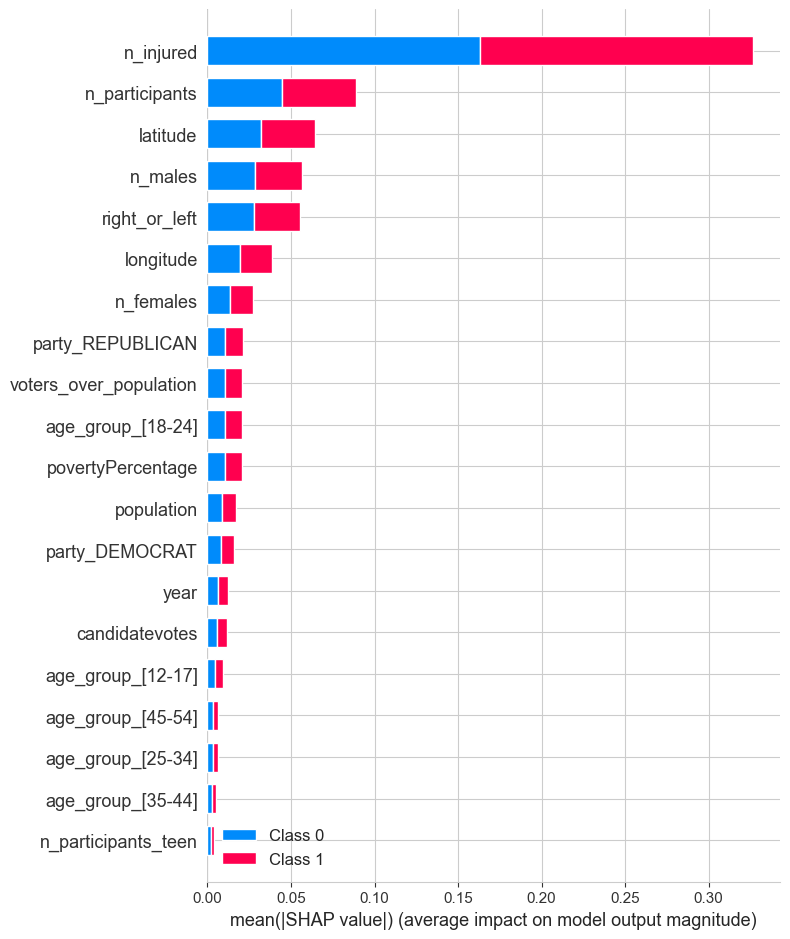

In [203]:
shap.summary_plot(shap_values_rf, X3_test_subsample)

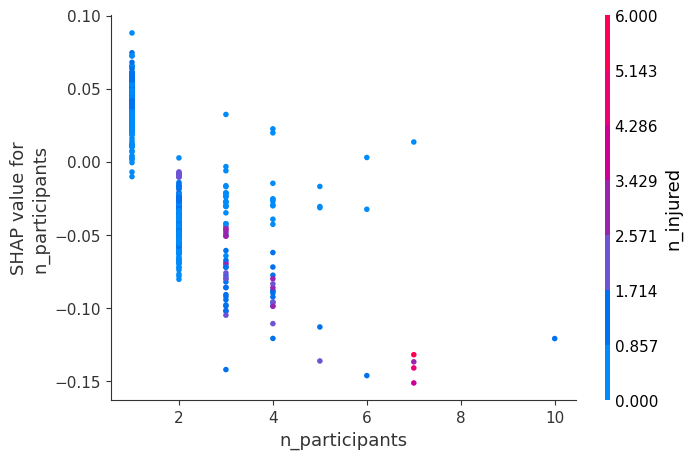

In [44]:
attr = "n_participants"
shap.dependence_plot(ind=attr, shap_values=shap_values_rf[0], features=X3_test_subsample)

In [278]:
# We decide to reapply expl_rf to the test set in order to have the SHAP values for the whole test set in the shap._explanation.Explanation object.

shap_values_randf = expl_rf(X3_test_subsample)

In [280]:
type(shap_values_randf)

shap._explanation.Explanation

In [292]:
np.shape(shap_values_randf.base_values)

(500, 2)

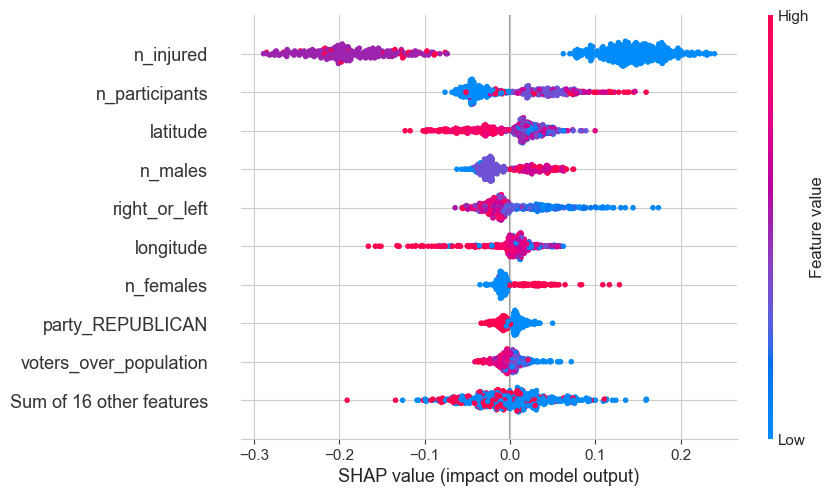

In [279]:
# summarize the effects of all the features with a beeswarm plot
shap.plots.beeswarm(shap_values_randf[:,:,1])

# Neural Network

## Loading and wrapping the best NN into scikeras

In [124]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.regularizers import l2

In [126]:
best_nn = Sequential([
                            Dense(32, activation='relu',
                                    input_shape=(X3_train.shape[1],), kernel_regularizer=l2(0.0001)),
                            Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
                            Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))
                            ]
                            )
best_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
best_nn.load_weights('../TASK 3/best_nn.h5')


In [138]:
from scikeras.wrappers import KerasClassifier

In [139]:
def create_model():
    return best_nn

In [155]:
nn_sklearn = KerasClassifier(model=create_model, epochs=0, batch_size=32, verbose=1)
nn_sklearn.fit(X3_train, y_train);

In [158]:
scaler = StandardScaler()
X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)


## Lime for NN

In [27]:
lime_nn = LimeTabular(data=X3_test_scaled, random_state=1, model=nn_sklearn, feature_names=X3_train.columns)

In [31]:
expl = lime_nn.explain_local(X3_test_scaled[85:87], y_test.iloc[85:87])

157/157 [==============================] - 0s 2ms/step


In [32]:
show(expl, 0)

<!-- http://127.0.0.1:7001/1392305130512/ -->

## Shap for NN

In [240]:
expl_nn = shap.GradientExplainer(best_nn, X3_train_scaled[0:100])
# We subsample the test set to speed up the explainer taking 1000 instances at random


In [253]:
explanations_nn = expl_nn(X3_test_scaled[0:10]);
shap_values_nn = expl_nn.shap_values(X3_test_scaled[0:10]);

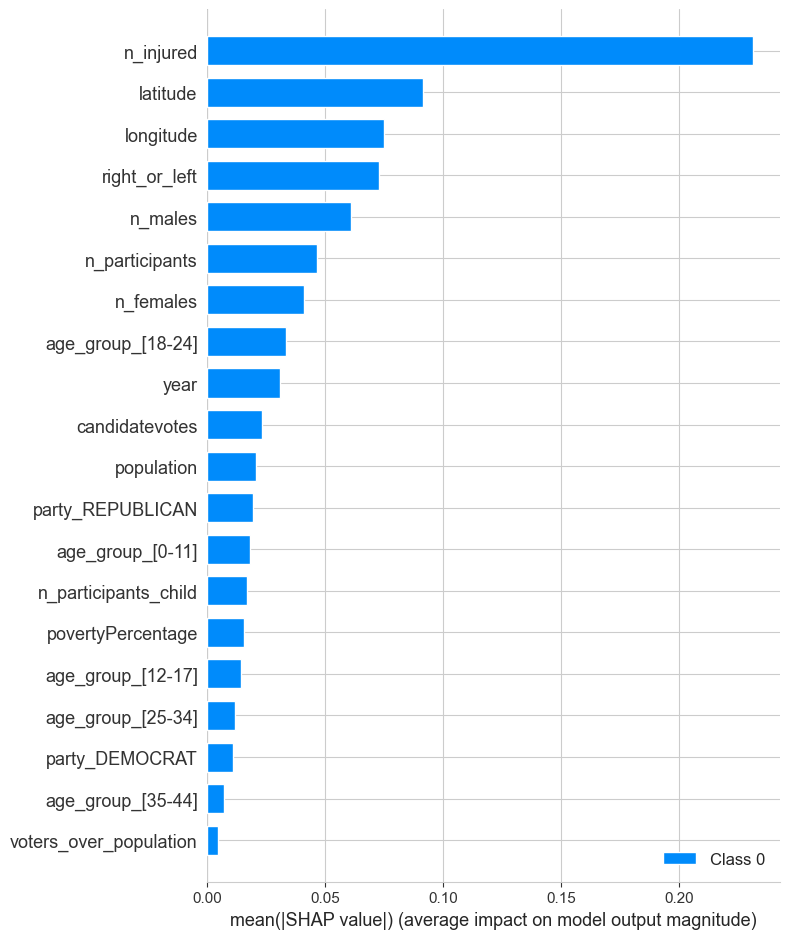

In [254]:
shap.summary_plot(shap_values_nn, X3_test_scaled[0:10], feature_names=X3_train.columns)


In [255]:
shap_values_nn[0].shape

(10, 25)

In [300]:
explanations_nn.base_values = np.ones((10,2))

In [303]:
explanations_nn.base_values=explanations_nn.base_values * np.array([.70, .30])
explanations_nn.base_values

array([[0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.7, 0.3]])

In [299]:
explanations_nn.values.append(-explanations_nn.values[0])

TypeError: object of type 'LinearSegmentedColormap' has no len()

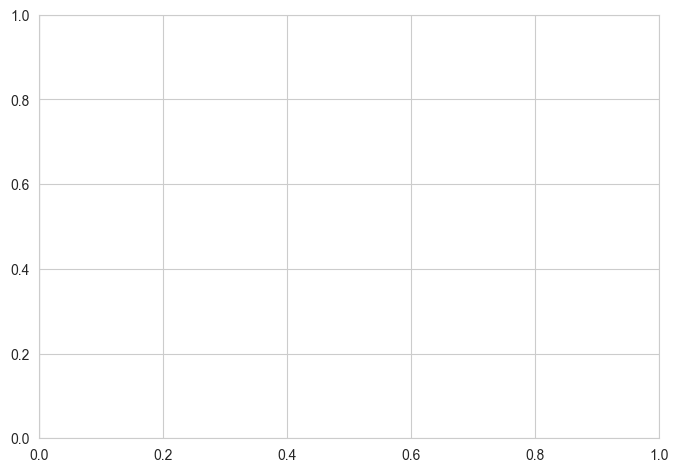

In [304]:
shap.plots.beeswarm(explanations_nn[0,:,:])

We didn't manage by any means to plot the SHAP beeswarm for Neural Network.

# EBM

In [71]:
from interpret.glassbox import ExplainableBoostingClassifier
import pickle

In [72]:
X3_train_prova= X3_train.head(30000)
y_train_prova=y_train.head(30000)
X3_train_prova.shape

(30000, 25)

In [73]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X3_train, y_train)

ExplainableBoostingClassifier()

In [74]:
evaluate_model(ebm, X3_train_prova, y_train_prova, X3_test, y_test)

Accuracy on training set:  0.7863666666666667
confusion_matrix on training set: 
 [[19264  2242]
 [ 4167  4327]]
Accuracy on validation set:  0.7891983905911483
Confusion matrix: 
 [[20930  2419]
 [ 4392  4569]]
Classification report: 
               precision    recall  f1-score   support

       False       0.83      0.90      0.86     23349
        True       0.65      0.51      0.57      8961

    accuracy                           0.79     32310
   macro avg       0.74      0.70      0.72     32310
weighted avg       0.78      0.79      0.78     32310



{'accuracy': 0.7891983905911483,
 'confusion_matrix': array([[20930,  2419],
        [ 4392,  4569]], dtype=int64),
 'classification_report': '              precision    recall  f1-score   support\n\n       False       0.83      0.90      0.86     23349\n        True       0.65      0.51      0.57      8961\n\n    accuracy                           0.79     32310\n   macro avg       0.74      0.70      0.72     32310\nweighted avg       0.78      0.79      0.78     32310\n'}

In [79]:
from interpret import show

ebm_global = ebm.explain_global(name='EBM Global')
show(ebm_global)

<!-- http://127.0.0.1:7001/2120141239200/ -->

In [83]:
ebm_local= ebm.explain_local(name='EBM Local', X=X3_test[85:86], y=y_test[85:86])
show(ebm_local)

<!-- http://127.0.0.1:7001/2120137527824/ -->